In [13]:
!mkdir flickr8k

mkdir: cannot create directory ‘flickr8k’: File exists


In [14]:
!mkdir working

mkdir: cannot create directory ‘working’: File exists


In [15]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [17]:
! cp kaggle.json ~/.kaggle/

In [18]:
! chmod 600 ~/.kaggle/kaggle.json

In [19]:
! kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:32<00:00, 44.0MB/s]
100% 1.04G/1.04G [00:32<00:00, 34.2MB/s]


In [20]:
!unzip /content/flickr8k.zip -d '/content/flickr8k'

Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: /content/flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: /content/flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/fli

In [21]:
import os 
import pickle 
import numpy as np 
from tqdm.notebook import tqdm 

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [22]:
BASE_DIR = '/content/flickr8k'
WORKING_DIR = '/content/working'

In [23]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [24]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [25]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [26]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [27]:
#Load the caption 
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [28]:
mapping = {}
for line in tqdm(captions_doc.split('\n')) :
    tokens = line.split(',')
    if len(line) < 2:
        continue 
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]

    caption = " ".join(caption)

    if image_id not in mapping :
        mapping[image_id] = []

    mapping[image_id].append(caption)       


  0%|          | 0/40456 [00:00<?, ?it/s]

In [29]:
len(mapping)

8091

In [30]:
# data preprocessing fo txt 

In [31]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1 ]) + 'endseq'
            captions[i] = caption 

In [32]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [33]:
clean(mapping)

In [34]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry wayendseq',
 'startseq girl going into wooden buildingendseq',
 'startseq little girl climbing into wooden playhouseendseq',
 'startseq little girl climbing the stairs to her playhouseendseq',
 'startseq little girl in pink dress going into wooden cabinendseq']

In [35]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [36]:
len(all_captions)

40455

In [37]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry wayendseq',
 'startseq girl going into wooden buildingendseq',
 'startseq little girl climbing into wooden playhouseendseq',
 'startseq little girl climbing the stairs to her playhouseendseq',
 'startseq little girl in pink dress going into wooden cabinendseq',
 'startseq black dog and spotted dog are fightingendseq',
 'startseq black dog and tri-colored dog playing with each other on the roadendseq',
 'startseq black dog and white dog with brown spots are staring at each other in the streetendseq',
 'startseq two dogs of different breeds looking at each other on the roadendseq',
 'startseq two dogs on pavement moving toward each otherendseq']

In [38]:
#tokenizing the text 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1 

In [39]:
vocab_size 

10886

In [40]:
max_lenght = max(len(caption.split()) for caption in all_captions)
max_lenght

34

In [41]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [42]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0



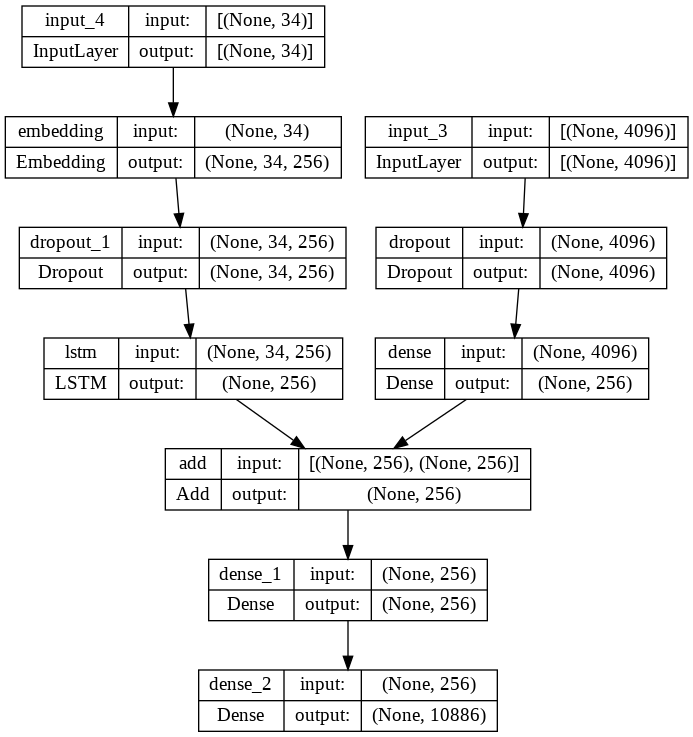

In [43]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_lenght,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',run_eagerly=True)

# plot the model
plot_model(model, show_shapes=True)

In [44]:
# train the model
epochs = 20
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_lenght, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 72s 635ms/step - loss: 2.4461


In [45]:
model.save(WORKING_DIR+'/best_model.h5')

In [55]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [56]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text   

In [57]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred  = predict_caption(model, features[key], tokenizer, max_lenght) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.337361
BLEU-2: 0.190038


In [58]:
#visulization the result 
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('-------------------Actual------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_lenght)
    print('---------------predict-----------')
    print(y_pred)
    plt.imshow(image)    

-------------------Actual------------------
startseq black dog and spotted dog are fightingendseq
startseq black dog and tri-colored dog playing with each other on the roadendseq
startseq black dog and white dog with brown spots are staring at each other in the streetendseq
startseq two dogs of different breeds looking at each other on the roadendseq
startseq two dogs on pavement moving toward each otherendseq
---------------predict-----------
startseq two dogs are playing together on the streetendseq with each otherendseq in the backgroundendseq endseq


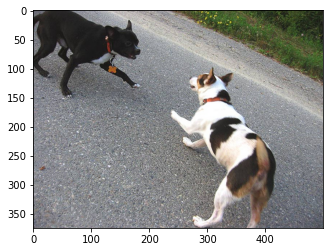

In [59]:
generate_caption("1001773457_577c3a7d70.jpg")

-------------------Actual------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowlendseq
startseq little girl is sitting in front of large painted rainbowendseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on itendseq
startseq there is girl with pigtails sitting in front of rainbow paintingendseq
startseq young girl with pigtails painting outside in the grassendseq
---------------predict-----------
startseq two girls in red dress climb on the grass next to the father and yellow flowers in the background endseq


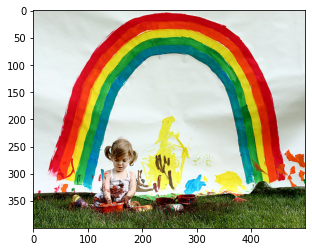

In [60]:
generate_caption("1002674143_1b742ab4b8.jpg")

-------------------Actual------------------
startseq man in hat is displaying pictures next to skier in blue hatendseq
startseq man skis past another man displaying paintings in the snowendseq
startseq person wearing skis looking at framed pictures set up in the snowendseq
startseq skier looks at framed pictures in the snow next to treesendseq
startseq man on skis looking at artwork for sale in the snowendseq
---------------predict-----------
startseq man in black jacket and black jacket is walking on the snow with paintings in the backgroundendseq endseq


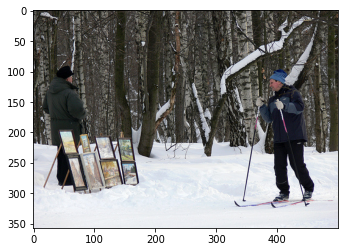

In [61]:
generate_caption("101669240_b2d3e7f17b.jpg")